## Reduce maintenance cost through predictive techniques

**Goal**  
Build a predictive model using machine learning to predict the probability of a device failure.   

**Target:** binary value 0 for non-failure and 1 for failure.  

**Data**  
[device_failure_dataset](http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv)

**Metadata**  

<table style="width: 286px; margin-left: 0px; " border=".1px" cellpadding=".1">
<tbody>
<tr style="height: 20px;">
<th style="height: 20px; text-align: right; width: 86px;">&nbsp;columns</th>
<th style="height: 20px; text-align: center; width: 198px;">&nbsp;description</th>
</tr>
<tr style="height: 20.3333px;">
<td style="height: 20.3333px; text-align: right; width: 86px;">&nbsp;date</td>
<td style="text-align: center; height: 20.3333px; width: 198px;">&nbsp;date of the event (yyyy-mm-dd)</td>
</tr>
<tr style="height: 20px;">
<td style="height: 20px; text-align: right; width: 86px;">&nbsp;device</td>
<td style="text-align: center; height: 20px; width: 198px;">&nbsp;device id</td>
</tr>
<tr style="height: 20px;">
<td style="height: 20px; text-align: right; width: 86px;">&nbsp;failure</td>
<td style="text-align: center; height: 20px; width: 198px;">&nbsp;non-failure (0), failure (1)</td>
</tr>
<tr style="height: 20px;">
<td style="height: 20px; text-align: right; width: 86px;">&nbsp;attributes 1-9</td>
<td style="text-align: center; height: 20px; width: 198px;">&nbsp;daily aggregated telemetry</td>
</tr>
</tbody>
</table>


In [1]:
#import libraries

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time

#Visualization
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

#Data preparation
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier


#Resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

#Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import (roc_auc_score, classification_report, 
                                confusion_matrix)

from sklearn.model_selection import GridSearchCV


%matplotlib inline

In [80]:
%load_ext autoreload
%autoreload 2

from utils_lxm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploratory Data Analysis

**The Data**

- 124.494 records
- There is no missing values
- All the variables are integer type, except for the device
- 304 days: from 2015-01-01 to 2015-11-02 (10 months)
- 1169 distinct devices
- The number of records decreases monthly

**Target**
- 106 failures  
    We don't find a device that fails more than once, so there are 106 device that have failed.  
    We can see different devices that failed in the same day.
    

In [3]:
df = pd.read_csv("C:/Users/laris/Documents/Estudos/cases/aws/data/device_failure.csv", encoding = 'latin')

In [4]:
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0          52           6      407438           0           0           7  
1           0           6      403174           0           0           0  
2           0          12      237394           0           0           0  
3           0           6      410186           0           0           0  
4           0          15      313173           0           0           3

In [5]:
#Example of device that failed

df[df.device == 'S1F0RRB1']

date    device  failure  attribute1  attribute2  attribute3  \
235   2015-01-01  S1F0RRB1        0     5230888        2288           0   
1398  2015-01-02  S1F0RRB1        0    13307628       64776           0   
2561  2015-01-03  S1F0RRB1        0    26258330       64776           0   
3724  2015-01-04  S1F0RRB1        0    37985862       64776           0   
4885  2015-01-05  S1F0RRB1        1    48467332       64776           0   

      attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
235           37           8       39267          24          24           1  
1398          49           8       39267          56          56           1  
2561         135           8       39267          56          56           1  
3724         763           8       39267          56          56           1  
4885         841           8       39267          56          56           1

In [6]:
print(df.shape)

(124494, 12)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [8]:
df.date.nunique()

304

In [9]:
df.failure.sum(), df[df.failure == 1].device.nunique()

(106, 106)

In [10]:
df[df.failure  == 1].date.value_counts().describe()

count    76.000000
mean      1.394737
std       0.924899
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       8.000000
Name: date, dtype: float64

In [11]:
df.describe()

failure    attribute1     attribute2     attribute3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.484762       9.940455   
std         0.029167  7.045933e+07    2179.657730     185.747321   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%         0.000000  6.128476e+07       0.000000       0.000000   
50%         0.000000  1.227974e+08       0.000000       0.000000   
75%         0.000000  1.833096e+08       0.000000       0.000000   
max         1.000000  2.441405e+08   64968.000000   24929.000000   

          attribute4     attribute5     attribute6     attribute7  \
count  124494.000000  124494.000000  124494.000000  124494.000000   
mean        1.741120      14.222669  260172.657726       0.292528   
std        22.908507      15.943028   99151.078547       7.436924   
min         0.000000       1.000000       8.000000       0.000000   
25%         0.000000       8.000000  221452.000000       0.000000   
50%         0.000000      10.000000  249799.500000       0.000000   
75%         0.000000      12.000000  310266.000000       0.000000   
max      1666.000000      98.000000  689161.000000     832.000000   

          attribute8     attribute9  
count  124494.000000  124494.000000  
mean        0.292528      12.451524  
std         7.436924     191.425623  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max       832.000000   18701.000000

**Volume of records**

In [12]:
x = clean_date(df,'date').date.value_counts()

source = pd.DataFrame({
  'date': x.index,
  'n_records': x.values
})

alt.Chart(source).mark_line().encode(
    x='date',
    y='n_records'
)

alt.Chart(...)

**Volume of failures**

In [13]:
df.date = df.date.astype(str)
x_failure_month = df.groupby(df.date.str[:7]).agg({'failure':'sum'}).reset_index()

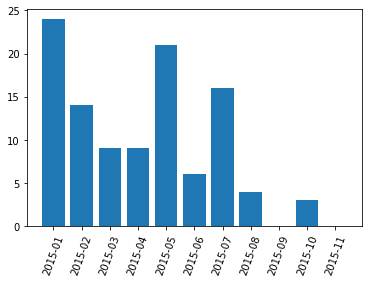

In [14]:
plt.bar( x = x_failure_month.date, height = x_failure_month.failure)

#x_labels = tuple(pd.Series(x_failure_month.date.str[5:].astype(int)).apply(n_month).values)
plt.xticks(rotation = 70)
plt.show()

**Correlation Between Variables**

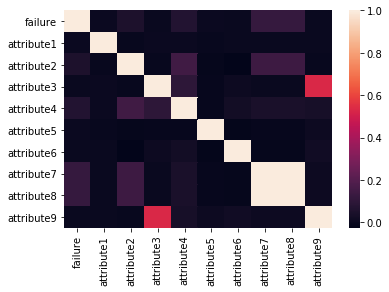

In [15]:
corr = df.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.show()

In [16]:
(df.attribute7 != df.attribute8).sum()

0

Attributes 7 and 8 are the same, so we can drop one of them.

**The Attributes**

C:\Users\laris\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\laris\AppData\Roaming\Python\Python37\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


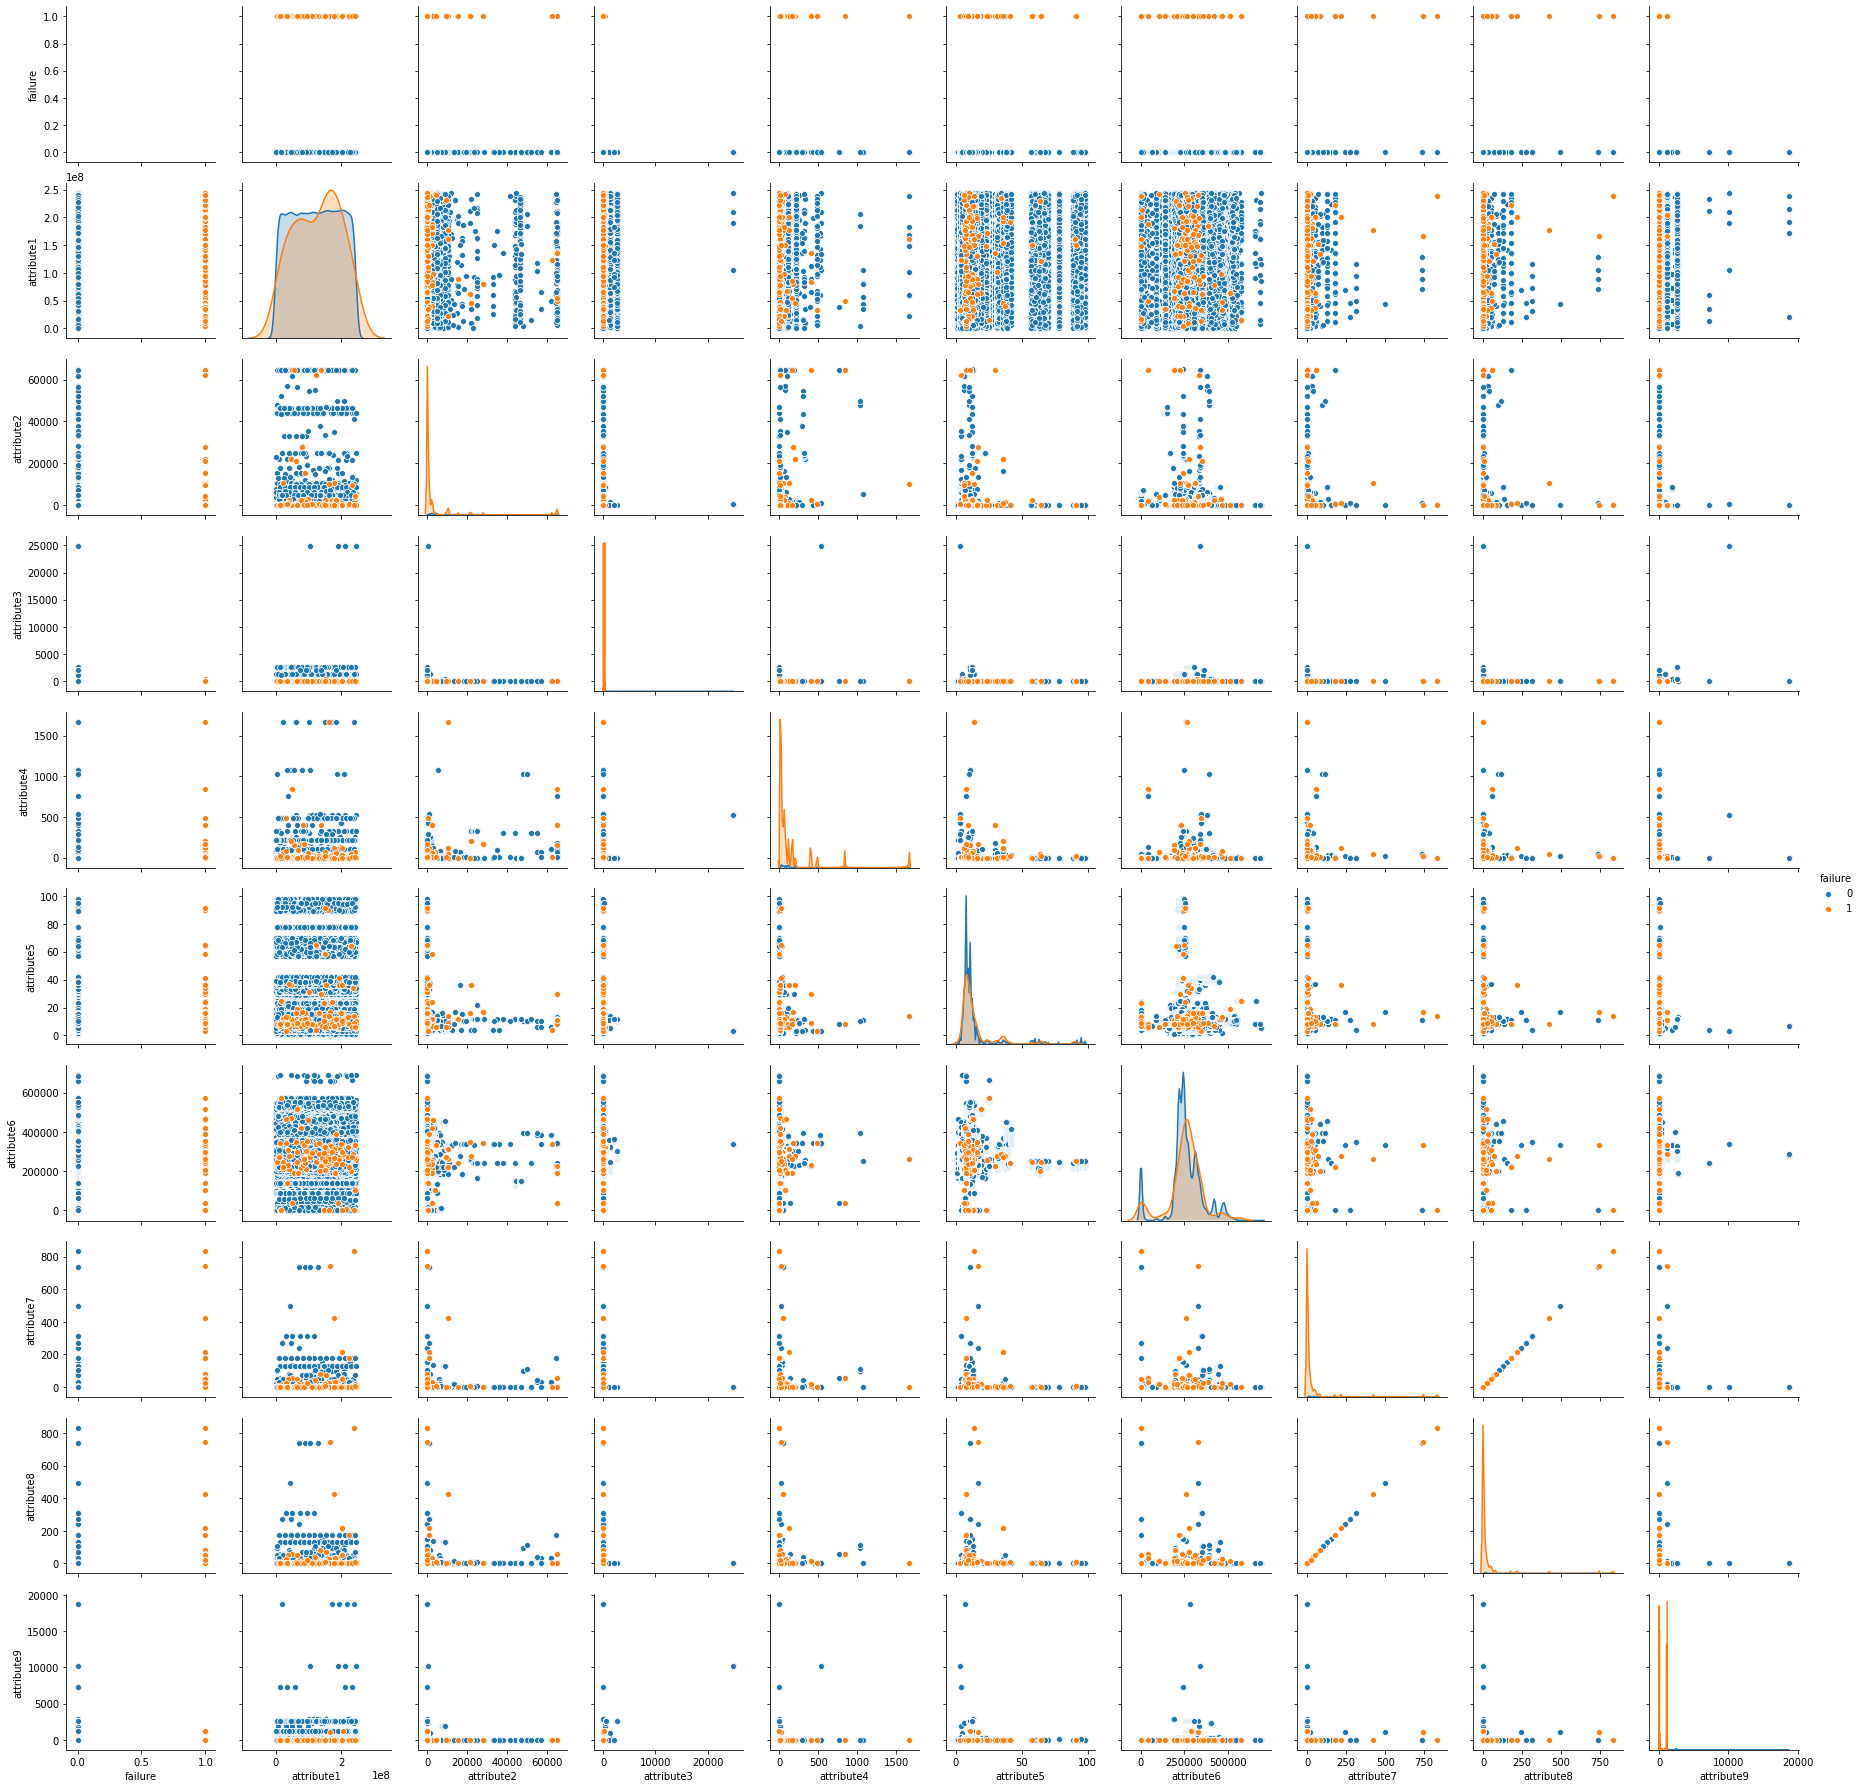

In [17]:
sns.pairplot(df, hue="failure")
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [19]:
df.nunique()

date             304
device          1169
failure            2
attribute1    123877
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

The attributes 3, 5, 7, 8 and 9 have limited number of distictive values, so they are likely to be a categorical variable.



In [20]:
df.describe()

failure    attribute1     attribute2     attribute3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.484762       9.940455   
std         0.029167  7.045933e+07    2179.657730     185.747321   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%         0.000000  6.128476e+07       0.000000       0.000000   
50%         0.000000  1.227974e+08       0.000000       0.000000   
75%         0.000000  1.833096e+08       0.000000       0.000000   
max         1.000000  2.441405e+08   64968.000000   24929.000000   

          attribute4     attribute5     attribute6     attribute7  \
count  124494.000000  124494.000000  124494.000000  124494.000000   
mean        1.741120      14.222669  260172.657726       0.292528   
std        22.908507      15.943028   99151.078547       7.436924   
min         0.000000       1.000000       8.000000       0.000000   
25%         0.000000       8.000000  221452.000000       0.000000   
50%         0.000000      10.000000  249799.500000       0.000000   
75%         0.000000      12.000000  310266.000000       0.000000   
max      1666.000000      98.000000  689161.000000     832.000000   

          attribute8     attribute9  
count  124494.000000  124494.000000  
mean        0.292528      12.451524  
std         7.436924     191.425623  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max       832.000000   18701.000000

In [21]:
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0          52           6      407438           0           0           7  
1           0           6      403174           0           0           0  
2           0          12      237394           0           0           0  
3           0           6      410186           0           0           0  
4           0          15      313173           0           0           3

In [22]:
min_att = df.groupby('device').agg({'attribute1':'min', 'attribute2':'min', 'attribute3':'min',
                         'attribute4':'min', 'attribute5':'min', 'attribute6':'min',
                         'attribute7':'min', 'attribute9':'min', 'failure':'min'})

In [23]:
max_att = df.groupby('device').agg({'attribute1':'max', 'attribute2':'max', 'attribute3':'max',
                         'attribute4':'max', 'attribute5':'max', 'attribute6':'max',
                         'attribute7':'max', 'attribute9':'max', 'failure': 'max'})

In [24]:
min_max_bool = (min_att != max_att)

In [25]:
min_max_bool[min_max_bool['failure']].sum(axis = 0) / min_max_bool['failure'].sum()

attribute1    1.000000
attribute2    0.415094
attribute3    0.009434
attribute4    0.500000
attribute5    0.443396
attribute6    0.962264
attribute7    0.367925
attribute9    0.075472
failure       1.000000
dtype: float64

In [26]:
min_max_bool.sum(axis = 0)/min_max_bool.shape[0]

attribute1    0.999145
attribute2    0.088109
attribute3    0.008554
attribute4    0.074423
attribute5    0.273738
attribute6    0.952951
attribute7    0.051326
attribute9    0.038494
failure       0.090676
dtype: float64

In [27]:
get_zeros(df).sort_index()

Feature   Zeros  Percent
0     failure  124388     99.9
1  attribute1      11      0.0
2  attribute2  118110     94.9
3  attribute3  115359     92.7
4  attribute4  115156     92.5
5  attribute7  123036     98.8
6  attribute8  123036     98.8
7  attribute9   97358     78.2

Even if we don't see the zero values, the standard deviation is still high:

In [28]:
df.describe()

failure    attribute1     attribute2     attribute3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.484762       9.940455   
std         0.029167  7.045933e+07    2179.657730     185.747321   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%         0.000000  6.128476e+07       0.000000       0.000000   
50%         0.000000  1.227974e+08       0.000000       0.000000   
75%         0.000000  1.833096e+08       0.000000       0.000000   
max         1.000000  2.441405e+08   64968.000000   24929.000000   

          attribute4     attribute5     attribute6     attribute7  \
count  124494.000000  124494.000000  124494.000000  124494.000000   
mean        1.741120      14.222669  260172.657726       0.292528   
std        22.908507      15.943028   99151.078547       7.436924   
min         0.000000       1.000000       8.000000       0.000000   
25%         0.000000       8.000000  221452.000000       0.000000   
50%         0.000000      10.000000  249799.500000       0.000000   
75%         0.000000      12.000000  310266.000000       0.000000   
max      1666.000000      98.000000  689161.000000     832.000000   

          attribute8     attribute9  
count  124494.000000  124494.000000  
mean        0.292528      12.451524  
std         7.436924     191.425623  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max       832.000000   18701.000000

In [29]:
df.mask(df== 0 ).describe()

failure    attribute1    attribute2    attribute3   attribute4  \
count    106.0  1.244830e+05   6384.000000   9135.000000  9338.000000   
mean       1.0  1.223989e+08   3110.102757    135.470936    23.212572   
std        0.0  7.045305e+07   9136.890893    673.232993    80.615440   
min        1.0  2.048000e+03      8.000000      1.000000     1.000000   
25%        1.0  6.129888e+07     96.000000      1.000000     4.000000   
50%        1.0  1.228013e+08    552.000000      5.000000     6.000000   
75%        1.0  1.833150e+08   2344.000000     56.000000    10.000000   
max        1.0  2.441405e+08  64968.000000  24929.000000  1666.000000   

          attribute5     attribute6   attribute7   attribute8    attribute9  
count  124494.000000  124494.000000  1458.000000  1458.000000  27136.000000  
mean       14.222669  260172.657726    24.978052    24.978052     57.124853  
std        15.943028   99151.078547    64.099492    64.099492    406.898449  
min         1.000000       8.000000     6.000000     6.000000      1.000000  
25%         8.000000  221452.000000     8.000000     8.000000      1.000000  
50%        10.000000  249799.500000     8.000000     8.000000      3.000000  
75%        12.000000  310266.000000    16.000000    16.000000     10.000000  
max        98.000000  689161.000000   832.000000   832.000000  18701.000000

**Continuous variables**

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

df_scaled = minmax_scaler.fit_transform(df.iloc[:, 3:])
df_scaled = pd.DataFrame(df_scaled, columns = df.columns[3:])

**Attribute 1**

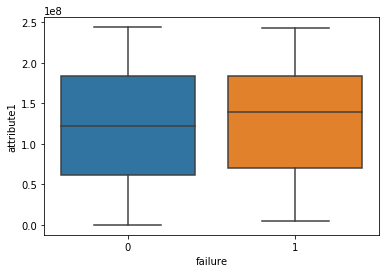

In [31]:
#sns.boxplot( y=df["attribute1"] )
sns.boxplot(x = df["failure"], y=df["attribute1"])
plt.show()

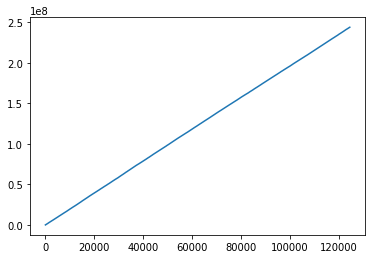

In [32]:
plt.plot(df["attribute1"].sort_values().reset_index(drop = True))

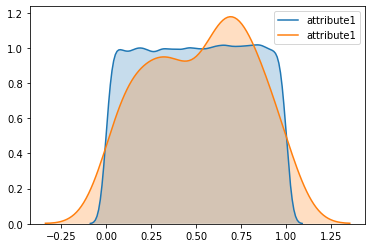

In [33]:
df_scaled['failure'] = df['failure'] 
sns.kdeplot(df_scaled.attribute1, shade =True)
sns.kdeplot(df_scaled[df_scaled.failure == 1].attribute1, shade =True)
plt.show()

**Attribute 6**

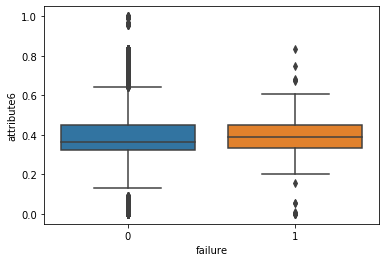

In [34]:
#sns.boxplot( y=df["attribute1"] )
sns.boxplot(x = df_scaled["failure"], y=df_scaled["attribute6"])
plt.show()

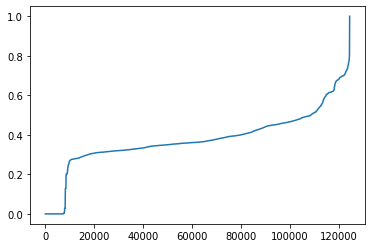

In [35]:
plt.plot(df_scaled["attribute6"].sort_values().reset_index(drop = True))

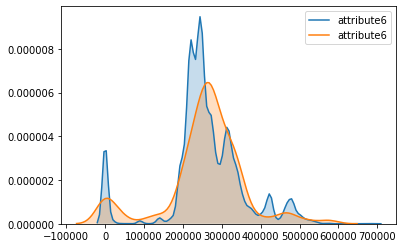

In [36]:
sns.kdeplot(df.attribute6, shade =True)
sns.kdeplot(df[df.failure == 1].attribute6, shade =True)
plt.show()

C:\Users\laris\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


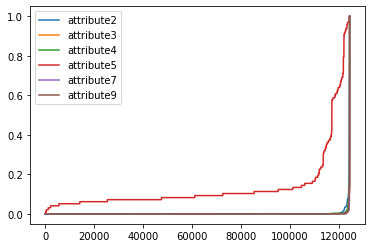

In [37]:
plt.plot(df_scaled["attribute2"].sort_values().reset_index(drop = True))
plt.plot(df_scaled["attribute3"].sort_values().reset_index(drop = True))
plt.plot(df_scaled["attribute4"].sort_values().reset_index(drop = True))
plt.plot(df_scaled["attribute5"].sort_values().reset_index(drop = True))
plt.plot(df_scaled["attribute7"].sort_values().reset_index(drop = True))
plt.plot(df_scaled["attribute9"].sort_values().reset_index(drop = True))
plt.legend(['attribute2','attribute3','attribute4', 'attribute5', 'attribute7', 'attribute9'])
plt.show()

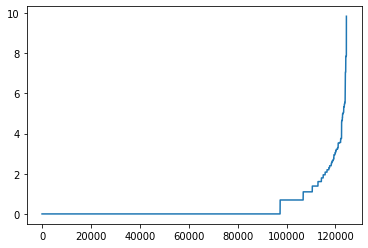

In [38]:
plt.plot(np.log(df["attribute9"].sort_values().reset_index(drop = True)+1))

In [39]:
np.log(df["attribute9"]+1).describe()

count    124494.000000
mean          0.395879
std           1.005991
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.836386
Name: attribute9, dtype: float64

In [40]:
df["attribute9"].describe()

count    124494.000000
mean         12.451524
std         191.425623
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18701.000000
Name: attribute9, dtype: float64

In [41]:
df_scaled.head()

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
0    0.883224    0.000862     0.00000    0.031212    0.051546    0.591204   
1    0.251374    0.000000     0.00012    0.000000    0.051546    0.585017   
2    0.709821    0.000000     0.00000    0.000000    0.113402    0.344461   
3    0.326427    0.000000     0.00000    0.000000    0.051546    0.595191   
4    0.556935    0.000000     0.00000    0.000000    0.144330    0.454420   

   attribute7  attribute8  attribute9  failure  
0         0.0         0.0    0.000374        0  
1         0.0         0.0    0.000000        0  
2         0.0         0.0    0.000000        0  
3         0.0         0.0    0.000000        0  
4         0.0         0.0    0.000160        0

In [37]:
df[df.failure == 0].device.str[:4].value_counts(normalize = True)

S1F0    0.266368
W1F0    0.187052
S1F1    0.174317
W1F1    0.160458
Z1F0    0.151590
Z1F1    0.058197
Z1F2    0.002018
Name: device, dtype: float64

In [38]:
df[df.failure == 1].device.str[:4].value_counts(normalize = True)

S1F0    0.339623
W1F0    0.254717
W1F1    0.141509
Z1F0    0.122642
Z1F1    0.084906
S1F1    0.056604
Name: device, dtype: float64

## Baseline model

In [39]:
df_scaled.head()

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
0    0.883224    0.000862     0.00000    0.031212    0.051546    0.591204   
1    0.251374    0.000000     0.00012    0.000000    0.051546    0.585017   
2    0.709821    0.000000     0.00000    0.000000    0.113402    0.344461   
3    0.326427    0.000000     0.00000    0.000000    0.051546    0.595191   
4    0.556935    0.000000     0.00000    0.000000    0.144330    0.454420   

   attribute7  attribute8  attribute9  failure  
0         0.0         0.0    0.000374        0  
1         0.0         0.0    0.000000        0  
2         0.0         0.0    0.000000        0  
3         0.0         0.0    0.000000        0  
4         0.0         0.0    0.000160        0

In [43]:
from sklearn.linear_model import LogisticRegression

# Create feature and target arrays
X = df_scaled.drop(columns = ["failure"])
y = df_scaled.failure

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, stratify= y)

# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.7909292416533633, 0.9625692789632921)

In [44]:
confusion_matrix(y_test, y_pred)

array([[35934,  1383],
       [   15,    17]], dtype=int64)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     37317
           1       0.01      0.53      0.02        32

    accuracy                           0.96     37349
   macro avg       0.51      0.75      0.50     37349
weighted avg       1.00      0.96      0.98     37349



## Feature Engineering

**Date based features**

In [46]:
df_scaled['date'] = df['date']
df_scaled['device'] = df['device']

#convert possible records from "date" to a datetime type
df_scaled = clean_date(df_scaled,'date')

In [47]:
df_scaled.head()

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
0    0.883224    0.000862     0.00000    0.031212    0.051546    0.591204   
1    0.251374    0.000000     0.00012    0.000000    0.051546    0.585017   
2    0.709821    0.000000     0.00000    0.000000    0.113402    0.344461   
3    0.326427    0.000000     0.00000    0.000000    0.051546    0.595191   
4    0.556935    0.000000     0.00000    0.000000    0.144330    0.454420   

   attribute7  attribute8  attribute9  failure       date    device  
0         0.0         0.0    0.000374        0 2015-01-01  S1F01085  
1         0.0         0.0    0.000000        0 2015-01-01  S1F0166B  
2         0.0         0.0    0.000000        0 2015-01-01  S1F01E6Y  
3         0.0         0.0    0.000000        0 2015-01-01  S1F01JE0  
4         0.0         0.0    0.000160        0 2015-01-01  S1F01R2B

In [48]:
df_scaled.set_index('date', inplace = True)

In [49]:
def generate_date_features(df, low_bound, high_bound):
    
    cal = ExampleCalendar()
    usa_holidays = pd.offsets.CustomBusinessDay(calendar=cal)
    low_bound, high_bound = span_year_range(low_bound,high_bound)
    holidays_usa = cal.holidays()
 
    
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['day_of_week'] = df.index.dayofweek
    df['week_of_year'] = df.index.weekofyear
    df['is_business_day'] = is_business_day(df)
    df['is_national_holiday'] = is_national_holiday(df, holidays_usa)

    df['is_month_start'] = pd.Series(df.index.is_month_start).apply(lambda x: 1 if x == True else 0).values
    df['is_month_end'] = pd.Series(df.index.is_month_end).apply(lambda x: 1 if x == True else 0).values
    df['is_quarter_start'] = pd.Series(df.index.is_quarter_start).apply(lambda x: 1 if x == True else 0).values
    df['is_quarter_end'] = pd.Series(df.index.is_quarter_end).apply(lambda x: 1 if x == True else 0).values
    
    return df

In [50]:
df_scaled = generate_date_features(df_scaled, '2015-01-01', '2015-11-02')
df_scaled.head()

attribute1  attribute2  attribute3  attribute4  attribute5  \
date                                                                     
2015-01-01    0.883224    0.000862     0.00000    0.031212    0.051546   
2015-01-01    0.251374    0.000000     0.00012    0.000000    0.051546   
2015-01-01    0.709821    0.000000     0.00000    0.000000    0.113402   
2015-01-01    0.326427    0.000000     0.00000    0.000000    0.051546   
2015-01-01    0.556935    0.000000     0.00000    0.000000    0.144330   

            attribute6  attribute7  attribute8  attribute9  failure  ...  \
date                                                                 ...   
2015-01-01    0.591204         0.0         0.0    0.000374        0  ...   
2015-01-01    0.585017         0.0         0.0    0.000000        0  ...   
2015-01-01    0.344461         0.0         0.0    0.000000        0  ...   
2015-01-01    0.595191         0.0         0.0    0.000000        0  ...   
2015-01-01    0.454420         0.0         0.0    0.000160        0  ...   

           month  quarter  day_of_week  week_of_year  is_business_day  \
date                                                                    
2015-01-01     1        1            3             1                1   
2015-01-01     1        1            3             1                1   
2015-01-01     1        1            3             1                1   
2015-01-01     1        1            3             1                1   
2015-01-01     1        1            3             1                1   

            is_national_holiday  is_month_start  is_month_end  \
date                                                            
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   

            is_quarter_start  is_quarter_end  
date                                          
2015-01-01                 1               0  
2015-01-01                 1               0  
2015-01-01                 1               0  
2015-01-01                 1               0  
2015-01-01                 1               0  

[5 rows x 22 columns]

**Device's operating days**

In [51]:
g = df_scaled.sort_values(by='date').groupby('device', as_index=False)
df_scaled['device_working_days'] = g.cumcount()


**Dropping 'attribute8' since it's correlated with the 'attribute7'**

In [52]:
df_scaled.drop(columns = 'attribute8', inplace = True)

In [53]:
df_scaled.head()

attribute1  attribute2  attribute3  attribute4  attribute5  \
date                                                                     
2015-01-01    0.883224    0.000862     0.00000    0.031212    0.051546   
2015-01-01    0.251374    0.000000     0.00012    0.000000    0.051546   
2015-01-01    0.709821    0.000000     0.00000    0.000000    0.113402   
2015-01-01    0.326427    0.000000     0.00000    0.000000    0.051546   
2015-01-01    0.556935    0.000000     0.00000    0.000000    0.144330   

            attribute6  attribute7  attribute9  failure    device  ...  \
date                                                               ...   
2015-01-01    0.591204         0.0    0.000374        0  S1F01085  ...   
2015-01-01    0.585017         0.0    0.000000        0  S1F0166B  ...   
2015-01-01    0.344461         0.0    0.000000        0  S1F01E6Y  ...   
2015-01-01    0.595191         0.0    0.000000        0  S1F01JE0  ...   
2015-01-01    0.454420         0.0    0.000160        0  S1F01R2B  ...   

            quarter  day_of_week  week_of_year  is_business_day  \
date                                                              
2015-01-01        1            3             1                1   
2015-01-01        1            3             1                1   
2015-01-01        1            3             1                1   
2015-01-01        1            3             1                1   
2015-01-01        1            3             1                1   

            is_national_holiday  is_month_start  is_month_end  \
date                                                            
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   
2015-01-01                    0               1             0   

            is_quarter_start  is_quarter_end  device_working_days  
date                                                               
2015-01-01                 1               0                    0  
2015-01-01                 1               0                    0  
2015-01-01                 1               0                    0  
2015-01-01                 1               0                    0  
2015-01-01                 1               0                    0  

[5 rows x 22 columns]

In [54]:
df_scaled.reset_index(drop= True, inplace = True)

In [55]:
df_scaled.columns

Index(['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5',
       'attribute6', 'attribute7', 'attribute9', 'failure', 'device', 'day',
       'month', 'quarter', 'day_of_week', 'week_of_year', 'is_business_day',
       'is_national_holiday', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'device_working_days'],
      dtype='object')

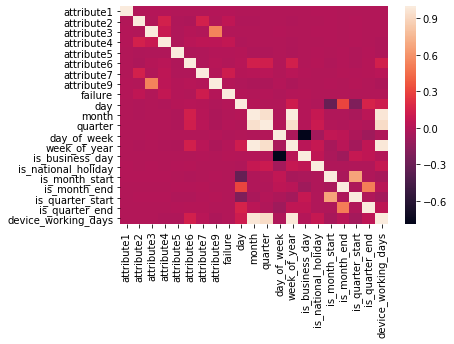

In [57]:
corr = df_scaled.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.show()

In [58]:
#Rescaling the dataset
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
df_columns = df_scaled.drop(columns = 'device').columns

df_scaled = minmax_scaler.fit_transform(df_scaled[df_columns])
df_scaled = pd.DataFrame(df_scaled, columns = df_columns)


## Resampling

### Undersampling

**Undersampling with randomized records**

In [203]:
n_failure = len(df_scaled[df_scaled['failure'] == 1])
non_failure_indices = len(df_scaled[df_scaled['failure'] == 0])
random_indices = np.random.choice(non_failure_indices,int(n_failure), replace=False)


failure_indices = df[df.failure == 1].index
under_sample_indices = np.concatenate([failure_indices,random_indices])

under_sample = df_scaled.loc[under_sample_indices]

# Create feature and target arrays
X = under_sample.drop(columns = 'failure')
y = under_sample.failure

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify= y)


clf = LogisticRegression(C = .001, penalty='l2',solver='saga', random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.6418918918918919, 0.59375)

In [204]:
X_train.shape, X_test.shape, y_train.sum(), y_test.sum()

((148, 20), (64, 20), 74.0, 32.0)

In [205]:
confusion_matrix(y_test, y_pred)

array([[19, 13],
       [13, 19]], dtype=int64)

In [207]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59        32
         1.0       0.59      0.59      0.59        32

    accuracy                           0.59        64
   macro avg       0.59      0.59      0.59        64
weighted avg       0.59      0.59      0.59        64



### Over-sampling

**Over-sampling using SMOTE (Synthetic Minority Oversampling Technique)**

SMOTE synthesises new minority instances between existing (real) minority instances. 

In [62]:
X = df_scaled.drop(columns = ['failure'])
y = df_scaled.failure

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, stratify= y)
print('Training set:', Counter(y_train), '\nTesting set:', Counter(y_test))

Training set: Counter({0.0: 87071, 1.0: 74}) 
Testing set: Counter({0.0: 37317, 1.0: 32})


In [63]:
# transform the dataset
oversample = SMOTE()
X_train_smt, y_train_smt = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train_smt)
print('Training set after over-sampling:', counter)


Training set after over-sampling: Counter({0.0: 87071, 1.0: 87071})


In [66]:
clf = LogisticRegression(C = .001, penalty='l2',solver='saga', random_state=42).fit(X_train_smt, y_train_smt)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

clf.score(X_train_smt, y_train_smt), clf.score(X_test, y_test)

(0.6555799290234406, 0.4629039599453801)

In [67]:
confusion_matrix(y_test, y_pred)

array([[17269, 20048],
       [   12,    20]], dtype=int64)

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.46      0.63     37317
         1.0       0.00      0.62      0.00        32

    accuracy                           0.46     37349
   macro avg       0.50      0.54      0.32     37349
weighted avg       1.00      0.46      0.63     37349



**Over-sampling using ADASYN**

Adaptive Synthetic creates more minority instances close to the (real) minority instances that have more majority in their "neighbourhood", generating more data for "harder to learn" examples"

In [69]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, stratify= y)
print('Training set:', Counter(y_train), '\nTesting set:', Counter(y_test))

Training set: Counter({0.0: 87071, 1.0: 74}) 
Testing set: Counter({0.0: 37317, 1.0: 32})


In [70]:
from imblearn.over_sampling import SMOTE, ADASYN

# transform the dataset
X_train_ads, y_train_ads = ADASYN().fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train_ads)
print('Training set after over-sampling:', counter)

Training set after over-sampling: Counter({0.0: 87071, 1.0: 87070})


In [71]:
clf = LogisticRegression(C = .001, penalty='l2',solver='saga', random_state=42).fit(X_train_ads, y_train_ads)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

clf.score(X_train_ads, y_train_ads), clf.score(X_test, y_test)

(0.6549520216376384, 0.4536132158826207)

In [72]:
confusion_matrix(y_test, y_pred)

array([[16922, 20395],
       [   12,    20]], dtype=int64)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.45      0.62     37317
         1.0       0.00      0.62      0.00        32

    accuracy                           0.45     37349
   macro avg       0.50      0.54      0.31     37349
weighted avg       1.00      0.45      0.62     37349



## Model Selection and Hyperparameter Tuning 

In [91]:
X = df_scaled.drop(columns = ['failure'])
y = df_scaled.failure

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, stratify= y)
print('Training set:', Counter(y_train), '\nTesting set:', Counter(y_test))

Training set: Counter({0.0: 87071, 1.0: 74}) 
Testing set: Counter({0.0: 37317, 1.0: 32})


In [75]:
print('Training set:', Counter(y_train_smt), '\nTesting set:', Counter(y_test))

Training set: Counter({0.0: 87071, 1.0: 87071}) 
Testing set: Counter({0.0: 37317, 1.0: 32})


In [267]:
import gc
gc.collect()

15141

In [133]:
rfc = RandomForestClassifier(bootstrap= True,
                             max_depth= 6,
                             max_features= 'auto',
                             min_samples_leaf= 2,
                             min_samples_split= 10,
                             n_estimators= 20,random_state=42)

rfc.fit(X_train_smt, y_train_smt)

y_pred = rfc.predict(X_test)
y_pred_proba_rfc = rfc.predict_proba(X_test)

print(rfc.score(X_test, y_test))
print(rfc.score(X_train, y_train))


0.9567859915928137
0.9575420276550577


In [77]:
confusion_matrix(y_test, y_pred)

array([[35715,  1602],
       [   12,    20]], dtype=int64)

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     37317
         1.0       0.01      0.62      0.02        32

    accuracy                           0.96     37349
   macro avg       0.51      0.79      0.50     37349
weighted avg       1.00      0.96      0.98     37349



**Setting a threshold probability for the negative values**

In [81]:
y_pred = prob_thr(y_pred_proba_rdf, 0.15)

In [82]:
print("We can predic ",recall_score(y_test, y_pred)*100,"% of the failures.")# and "+(1- recall_score(y_test, y_pred))*100+"of)


We can predic  78.125 % of the failures.


In [83]:
confusion_matrix(y_test,  y_pred)

array([[30224,  7093],
       [    7,    25]], dtype=int64)

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89     37317
         1.0       0.00      0.78      0.01        32

    accuracy                           0.81     37349
   macro avg       0.50      0.80      0.45     37349
weighted avg       1.00      0.81      0.89     37349



In [85]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8975111041884396

**LGBM**

In [92]:
X_train_smt.shape, y_train.shape


((174142, 20), (87145,))

In [93]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train_smt, label=y_train_smt)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [100]:
y_pred_proba = clf.predict(X_test)
#y_pred_proba = clf.predict_proba(X_test)

print(rfc.score(X_test, y_test))
print(rfc.score(X_train, y_train))

0.9567859915928137
0.9575420276550577


In [102]:
def prob_thr2(y_proba, thr):
    f = lambda x: 0 if x < thr else 1
    return [f(x) for x in y_proba]

In [122]:
y_pred = prob_thr2(y_pred_proba, .5)

In [123]:
confusion_matrix(y_test,  y_pred)

array([[35376,  1941],
       [   10,    22]], dtype=int64)

In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     37317
         1.0       0.01      0.69      0.02        32

    accuracy                           0.95     37349
   macro avg       0.51      0.82      0.50     37349
weighted avg       1.00      0.95      0.97     37349



No Skill: ROC AUC=0.500
LGBM: ROC AUC=0.912
RandomForest: ROC AUC=0.898


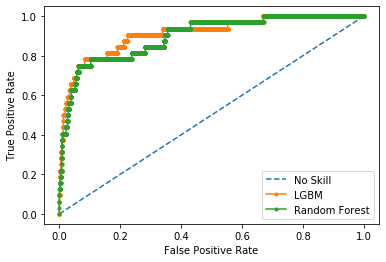

In [134]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
#lr_probs = model.predict_proba(testX)


# keep probabilities for the positive outcome only
y_pred_proba_rfc = y_pred_proba_rfc[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lgbm_auc = roc_auc_score(y_test, y_pred_proba)
rfc_auc = roc_auc_score(y_test, y_pred_proba_rfc)


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
print('RandomForest: ROC AUC=%.3f' % (rfc_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, y_pred_proba)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, y_pred_proba_rfc)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='LGBM')
pyplot.plot(rfc_fpr, rfc_tpr, marker='.', label='Random Forest')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

**Hyperparameter Tuning**

In [141]:
from imblearn.pipeline import Pipeline

model = Pipeline([
        ('sampling', SMOTE()),
        ('classification',  RandomForestClassifier())
    ])

n_estimators = [25, 50, 75, 100]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10, 20, 50]
min_samples_leaf = [ 2, 5, 10] 

hyper = dict(classification__n_estimators = n_estimators,
             classification__max_depth = max_depth,  
             classification__min_samples_split = min_samples_split, 
             classification__min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(model, hyper, cv = 3, scoring='recall', verbose = 3, n_jobs = 6) 

best = grid.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   34.4s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 540 out of 540 | elapsed: 24.8min finished


In [142]:
grid.best_estimator_

Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        min_samples_split=20,
                                        n_estimators=25))])

In [145]:
grid.best_score_

0.5394444444444444

## Conclusion

Since it is an imbalanced classification problem, it is important to balance the training set in order to obtain a decent classifier. For this, SMOTE (Synthetic Minority Over-sampling Technique) and ADASYN (Adaptive Synthetic) techniques were compared and SMOTE showed better results.

RandomForest classifier achieved an accuracy score of about 0.95 in both training and testing set. However, focus on the positive values is more interesting, so we can predict better the devices that are going to fail. For this purpose, it was setted a threshold value to improve the recall. In the end, we got a recall score of 0.78 with an accuracy score of 0.81. 

In order to produce better results, further studies about handling zero-inflation data may improve the over-sampling process which wokrs with distance values between the features.
Furthermore collecting data of the beggining of the devices operation will allow us to analize the expected duration of the time until the devices fails, using Survival Analysis. 
